## Movie Recommender with Item-Item collaborative filtering

We will create a movie recommender using item - item collaborative filtering logic.

The datasets available for this exercise is as follows:

 - **movies**  : This dataset has the movieId and the name and details of all the movies in the database.
 - **ratings** : This dataset has the ratings given by each userId to the movieId they have seen.
 
### The idea behind recommending movies to user based on item-item collaborative filtering is as follows :

 - **Step 1.** Create a adjusted rating for all movies by users. This adjusted rating is calculated by subtracting the movie's average rating from all users ($\mu_j$ for movie j) from each rating for that movie.
 - **Step 2.** Calculate similarity scores between all movies based on their adjusted movie ratings from each user (use cosine similarity). For recommendation purpose we will only consider top similar movies to a target movie (top n nearest neighbours). 
 - **Step 3.** For recommending a movie to a target user we will score each movie, using the top n nearest neighbours for that movie. The score is basically a weighted rating based on the target user's rating for all movies they have rated and the similarity scores as the weight. once we score all the movies, pick the top scoring movies from this scoring as recommendations. 

In [265]:
# import key libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import gc
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity as cs

%matplotlib inline

sns.set(style='darkgrid')
sns.set(font_scale=1.5)

# import datasets

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [266]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [267]:
ratings.head()

,userId,movieId,rating,timestamp
0,12882,1,4.0,1147195252
1,12882,32,3.5,1147195307
2,12882,47,5.0,1147195343
3,12882,50,5.0,1147185499
4,12882,110,4.5,1147195239


In [268]:
# Get basic information about the datasets

print movies.shape, ratings.shape
print 'Unique movies : ', movies['movieId'].nunique()
print 'Unique users in ratings data : ', ratings['userId'].nunique()
print 'Unique movies in ratings data : ', ratings['movieId'].nunique()

(2500, 3) (264505, 4)
Unique movies :  2500
Unique users in ratings data :  862
Unique movies in ratings data :  2500


### Step 1: Create adjusted user movie rating

The adjusted rating is nothing but the average rating for the movie from all users ($\mu_j$) subtracted from all of the individual movie ratings ($r_{uj}$)

\begin{equation*}
R_{uj} = r_{uj} - \mu_j
\end{equation*}

This adjusted rating is now comparable across all movies. This adjusted score basically compares the variation of ratings by a user from the movie's mean rating.

In [269]:
# adjust ratings for each movie user combo
movie_ratings = ratings.groupby(by='movieId', as_index=False).agg({'rating' : 'mean'}).reset_index(drop=True)
movie_ratings = movie_ratings.rename(columns={'rating':'avg_rating'})

ratings_adj = ratings.merge(movie_ratings,on='movieId', how='inner')
ratings_adj['rating_adj'] = ratings_adj['rating'] - ratings_adj['avg_rating']

ratings_adj.head()

,userId,movieId,rating,timestamp,avg_rating,rating_adj
0,12882,1,4.0,1147195252,3.793347,0.206653
1,121987,1,4.5,1308152264,3.793347,0.706653
2,18127,1,4.0,1130946329,3.793347,0.206653
3,17318,1,4.0,1168807334,3.793347,0.206653
4,69519,1,4.0,1303980621,3.793347,0.206653


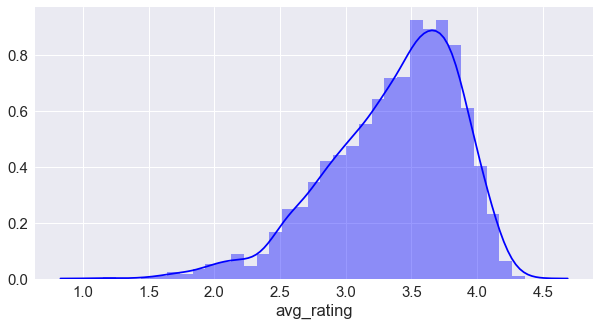

In [270]:
# Plotting Average ratings across all users
f, ax = plt.subplots(figsize = (10,5))
sns.distplot(movie_ratings['avg_rating'], color='blue')

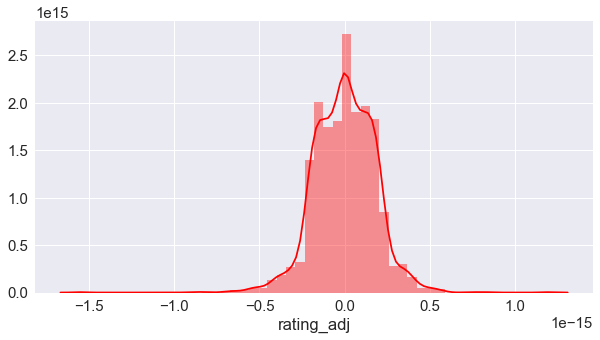

In [271]:
# Plotting Average adjusted ratings across all users
f, ax = plt.subplots(figsize = (10,5))
sns.distplot(ratings_adj.groupby(by='movieId', as_index=False).\
             agg({'rating_adj' : 'mean'})['rating_adj'], color='red')

### Step 2: Create similarity score for each movie with every other movie

For creating this similarity score we will use the cosine similarity.


\begin{equation*}
cos(i,j) = \frac{R_i.R_j}{||R_i||.||R_j||} = \frac{\sum_{u} R_{ui}.R_{uj}}{\sqrt{\sum_{u}R_{ui}^2}.\sqrt{\sum_{u}R_{uj}^2}} 
\end{equation*}

where,

1. $cos(i,j)$ is the cosine similarity score for movie I and movie J
2. $R_i$ and $R_j$ are the rating vector of movie I and movie J from all the users U
3. summation over all users U

In [272]:
# create a transformed dataset for user and movieid level to get the adjusted ratings
ratings_adj_tf = ratings_adj[['userId', 'movieId', 'rating_adj']].\
                    pivot(index='movieId', columns='userId', values='rating_adj').fillna(0)
print ratings_adj_tf.shape

# similarity matrix - cosine distance
dist = pd.DataFrame(data=cs(ratings_adj_tf), index=ratings_adj_tf.index, columns=ratings_adj_tf.index)
print dist.shape

dist.head()

(2500, 862)
(2500, 2500)


movieId,1,2,3,4,5,6,7,9,10,11,...,106487,106489,106782,106920,109374,109487,111362,111759,112556,112852
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.213859,0.141760,-0.008966,0.097387,0.142986,0.098391,-0.002693,0.249048,0.064682,...,0.091836,0.039616,0.000838,-0.062027,0.014948,-0.023641,0.033899,0.118078,0.009632,0.027987
2,0.213859,1.000000,0.218855,0.038701,0.125331,0.088945,0.154515,0.087974,0.231964,0.045029,...,0.002335,0.070117,0.007135,0.020423,0.025387,-0.008621,0.055854,0.100682,0.017698,-0.005051
3,0.141760,0.218855,1.000000,0.056912,0.194855,0.067841,0.215001,0.084497,0.238945,-0.042045,...,0.035813,0.000563,0.006274,-0.013847,-0.067057,0.005918,0.035625,0.051791,0.004455,0.006536
4,-0.008966,0.038701,0.056912,1.000000,0.130774,0.014619,0.165135,0.008468,0.002328,0.054559,...,0.015719,-0.001914,-0.023196,0.000000,-0.069161,0.022617,-0.004701,-0.004050,0.014739,0.003485
5,0.097387,0.125331,0.194855,0.130774,1.000000,0.014217,0.135021,0.033035,0.070476,0.295026,...,0.009895,0.006920,-0.016611,-0.078513,-0.101702,-0.008514,0.020842,-0.030210,0.042158,-0.012994


### Step 3: Create a recommendation for a given target user

To recommend a movie to the target user we have to find a score for each movie in the dataset for this user and the movies with the highest scores will be recommended to the user. Steps for scoring each movie for the target user - 

1. Get the list of movies target user has rated (seen movies). These seen movies will be used to create the score for all other movies (unseen movies) based on how the unseen movies are similar to these seen movies. These seen movies tell us about the taste of the target user. If they have rated some movies high, we will try to find similar unseen movies to these high rated seen movies and recommend them to the user and vice versa for low rated movies.

2. For all the unseen movies in the dataset get the the similarity scores between them and the seen movies.

3. Using the similarity scores between each of the unseen movies and the seen movies, calculate a score for the unseen movies. The formula for the score is given below.

4. Once we get the score, sort the unseen movies based on the score and recommend the top n movies for the user.

**Formula for score -**

\begin{equation*}
S_{u,i} =  \mu_u + \frac{\sum_{j} cos(i,j).(r_{uj} - \mu_j)}{\sum_{j} cos(i,j)}
\end{equation*}

where,
 - $S_{u,i}$ is the score for the unseen movie i
 - $\mu_u$ is the average rating for all seen movies by target user U
 - $cos(i,j)$ is the cosine similarity (based on adjusted rating) between unseen movie i and the seen movie j
 - $r_{uj}$ is the rating of the seen movie j by target user U
 - $\mu_j$ is the average rating from all users for the seen movie j
 - $(r_{uj} - \mu_j)$ is the same as the adjusted rating calculated above $R_{uj}$

**The steps for creating a recommendation for the target user will be in form of a function.**

In [273]:
# average rating by all the users for their seen movies
# this will be useful in getting target user's average rating
user_rating = ratings.groupby(by='userId', as_index=False).agg({'rating':'mean', 'movieId':'count'})\
                .reset_index(drop=True)
user_rating = user_rating.rename(columns={'rating':'avg_user_rating', 'movieId':'rated_movies'})
user_rating = user_rating.sort_values(by='rated_movies', ascending=False).reset_index(drop=True)

In [274]:
# users with max movies rated
user_rating.head()

,userId,avg_user_rating,rated_movies
0,76630,2.993158,1900
1,133811,4.269775,1555
2,70201,3.051368,1499
3,79531,3.222742,1495
4,42096,3.366147,1412


In [275]:
# users with very less movies rated
user_rating.tail()

,userId,avg_user_rating,rated_movies
857,8335,3.882353,17
858,83479,3.562500,16
859,128079,3.366667,15
860,56478,3.300000,15
861,138176,4.107143,14


In [276]:
# function which takes a user id and returns movie list with top recommendations

def top_movie_reco(user):
    
    #####
    # 1. the seen movies or the rated movies by the user
    movie_already_rated = ratings_adj[ratings_adj['userId'] == user][['movieId', 'rating_adj']].reset_index(drop=True)
    
    #####
    # 2. the similarity metrics between the seen and unseen movies
    dist_temp = dist.copy()
    dist_temp.reset_index(inplace=True)
    # transform the distance table to long form
    dist_temp = pd.melt(dist_temp, id_vars=['movieId'], value_vars=list(dist_temp.columns)[1:]\
                        , var_name='unseen_movie', value_name='similarity')
    dist_temp = dist_temp.merge(movie_already_rated, on='movieId', how='inner')
    dist_temp = dist_temp.sort_values(by=['unseen_movie', 'movieId'], ascending=[True, True]).reset_index(drop=True)
    # replace the negative similarity with 0
    dist_temp.loc[dist_temp['similarity'] < 0, ['similarity']] = 0
    
    #####
    # 3. calculate the score for each unseen movie
    dist_temp['wgt_score'] = dist_temp['rating_adj'] * dist_temp['similarity']
    movie_scores = dist_temp.groupby(by='unseen_movie', as_index=False)\
                    .agg({'wgt_score':'sum', 'similarity':'sum'}).reset_index(drop=True)
    movie_scores['score'] = user_rating[user_rating['userId'] == user].iloc[0,1] + \
                                (movie_scores['wgt_score']/movie_scores['similarity'])
    movie_scores = movie_scores.sort_values(by='score', ascending=False).reset_index(drop=True)
    movie_scores = movie_scores.rename(columns={'unseen_movie':'movieId'})
    
    #####
    # 4. remove the movies already rated by the user
    movie_already_rated = list(ratings[ratings['userId'] == user][['movieId']].iloc[:,0])
    movie_scores = movie_scores[~movie_scores['movieId'].isin(movie_already_rated)]
    
    #####
    # 5. get the details of the movies - title, genre
    movie_scores = movie_scores.merge(movies, on='movieId', how='inner')
    
    #####
    # 6. delete temp tables
    del dist_temp
    del movie_already_rated
    
    #####
    # 7. return the scored movie list
    return movie_scores[['movieId', 'title', 'genres', 'score']]

In [277]:
# check for one of the user who has max movies rated
targ_user = 76630

st = time.time()
top_mvs = top_movie_reco(targ_user)
et = time.time()

print "Time to recommend : ", round((et-st),2), " secs"
top_mvs.head(10)

Time to recommend :  4.36  secs


,movieId,title,genres,score
0,1014,Pollyanna (1960),Children|Comedy|Drama,2.729696
1,1931,Mutiny on the Bounty (1935),Adventure|Drama,2.721174
2,1041,Secrets & Lies (1996),Drama,2.720563
3,3467,Hud (1963),Drama|Western,2.706404
4,6104,Monty Python Live at the Hollywood Bowl (1982),Comedy,2.703441
5,947,My Man Godfrey (1936),Comedy|Romance,2.703170
6,69757,(500) Days of Summer (2009),Comedy|Drama|Romance,2.703099
7,156,Blue in the Face (1995),Comedy|Drama,2.702224
8,1250,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War,2.702052
9,828,"Adventures of Pinocchio, The (1996)",Adventure|Children,2.699860


In [278]:
# check for one of the user who has min movies rated
targ_user = 83479

st = time.time()
top_mvs = top_movie_reco(targ_user)
et = time.time()

print "Time to recommend : ", round((et-st),2), " secs"
top_mvs.head(10)

Time to recommend :  0.87  secs


,movieId,title,genres,score
0,3285,"Beach, The (2000)",Adventure|Drama,5.500535
1,3307,City Lights (1931),Comedy|Drama|Romance,5.489775
2,1233,"Boot, Das (Boat, The) (1981)",Action|Drama|War,5.446385
3,57,Home for the Holidays (1995),Drama,5.418844
4,421,Black Beauty (1994),Adventure|Children|Drama,5.414732
5,2130,Atlantic City (1980),Crime|Drama|Romance,5.408917
6,106920,Her (2013),Drama|Romance|Sci-Fi,5.375187
7,66934,Dr. Horrible's Sing-Along Blog (2008),Comedy|Drama|Musical|Sci-Fi,5.373053
8,3396,"Muppet Movie, The (1979)",Adventure|Children|Comedy|Musical,5.366766
9,509,"Piano, The (1993)",Drama|Romance,5.348544
